In [2]:
#cv2: sirve para el procesamiento de imágenes y videos en Python
#Pyplot: permite crear gráficos.
#Numpy: en palabras sencillas sirve para trabajar con muchos números de manera rápida y ordenada
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np


# FUNCION para crear plots 
def plots(imgArray, subtitles, title):

  fig = plt.figure(figsize=(7*len(imgArray),5)) # crea un contenedor | ancho y alto 
  fig.suptitle(title) # crea un titulo a las imagenes
  i=0
  for img in imgArray: #recorre el arreglo de imagenes
    i = i+1 
    axes = fig.add_subplot(1,len(imgArray),i) #no. filas, no. de columnas, index donde se "dibujara"|crea sub-contenedores
    axes.set_title(subtitles[i-1]) #crea subtitulo para el sub-contenedor
    fig.subplots_adjust(wspace=.2,hspace=0.2) #separacion entre sub-contenedores
    imgplot =plt.imshow(img)
  plt.show()
  

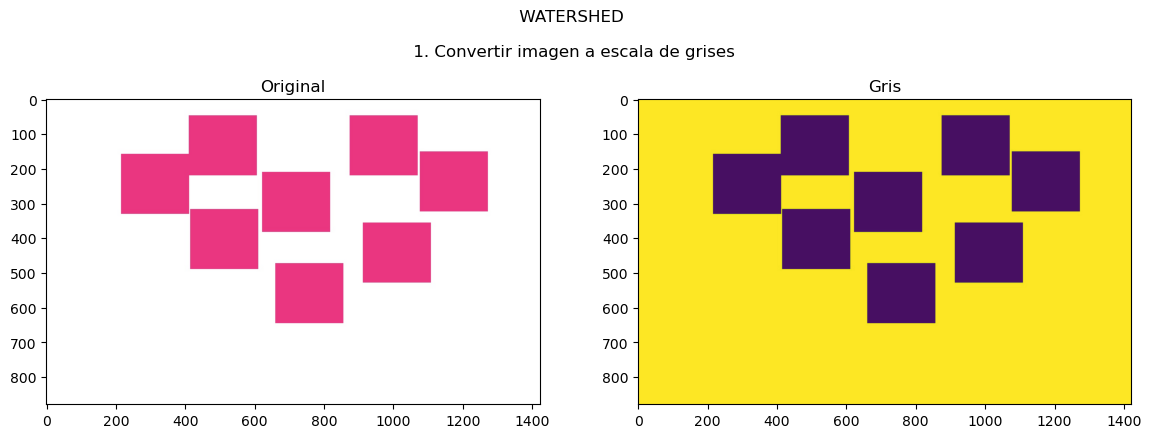

In [11]:
#Se crea una variable que contiene la ruta de la imagen
#ruta = "imagenes\\mapa.jpg"
#ruta= "imagenes\\billetes20color.jpg"
#ruta = "imagenes\\mapa-azul.jpg"
ruta = "imagenes\\rectangulos.jpg"
#ruta="imagenes\lago.jpg"

#1. Convertir imagen a escala de grises
#leer imagen
#debemos transformar la imagen a RGB ya que plt usa RGB y cv usa BGR
imgOriginal = cv.imread(ruta,cv.IMREAD_COLOR_RGB) 
imgOriginal2 = cv.imread(ruta) 
imgGrisBRG = cv.imread(ruta,cv.IMREAD_GRAYSCALE)
imgGris= cv.cvtColor(imgGrisBRG,cv.COLOR_BGR2RGB) 
imgGris2= cv.cvtColor(imgOriginal2,cv.COLOR_BGR2GRAY) 

plots([imgOriginal,imgGris2],["Original","Gris"]," WATERSHED \n\n 1. Convertir imagen a escala de grises")

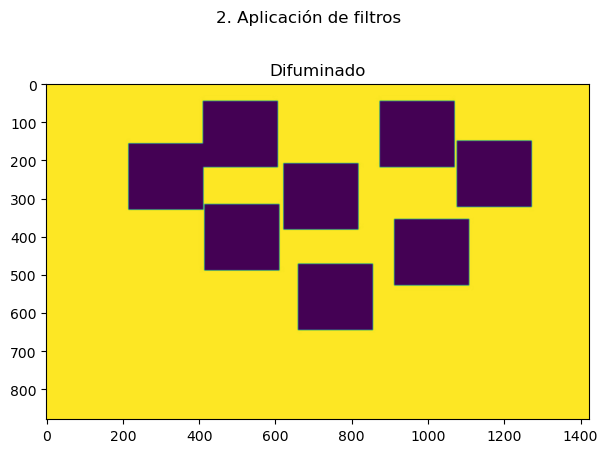

In [12]:
#2. Aplicación de filtros
blur = cv.GaussianBlur(imgGris2,(5,5),0)
plots([blur],["Difuminado"],"2. Aplicación de filtros")

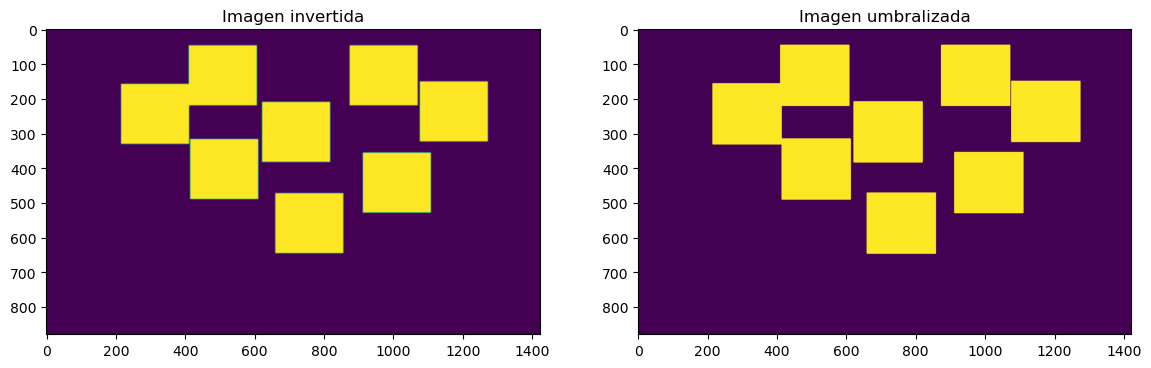

In [13]:
#Aqui se separa el forground de el background 
#Lo inverti para que el fondo fuera obscuro y el objeto claro
invertida=  cv.bitwise_not(blur) 
#Este thresh (THRESH_TRIANGLE) toma todos los colores y encuentra automaticamente el mejor punto para dividir la imagen entre claro y obscuro
_,thresh = cv.threshold(invertida,None,255,cv.THRESH_TRIANGLE) 
plots([invertida,thresh],["Imagen invertida","Imagen umbralizada"],"")



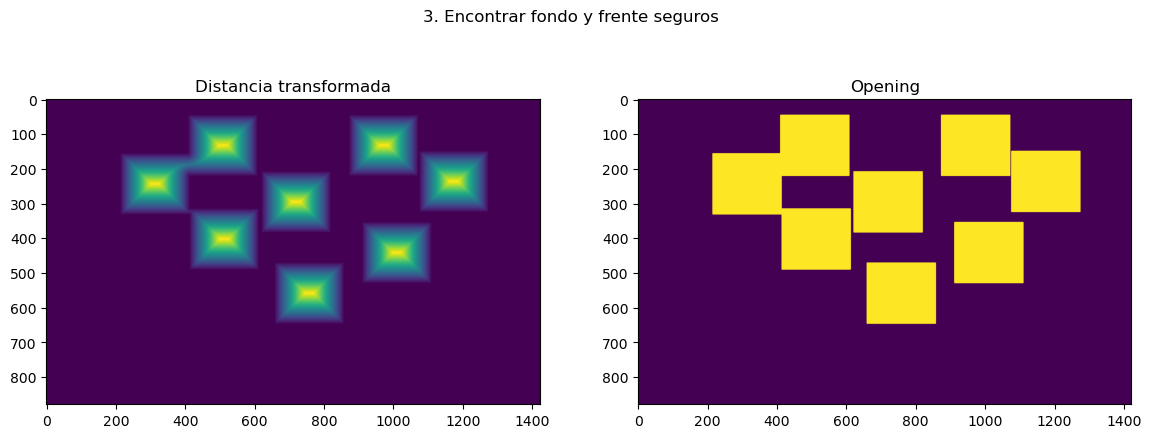

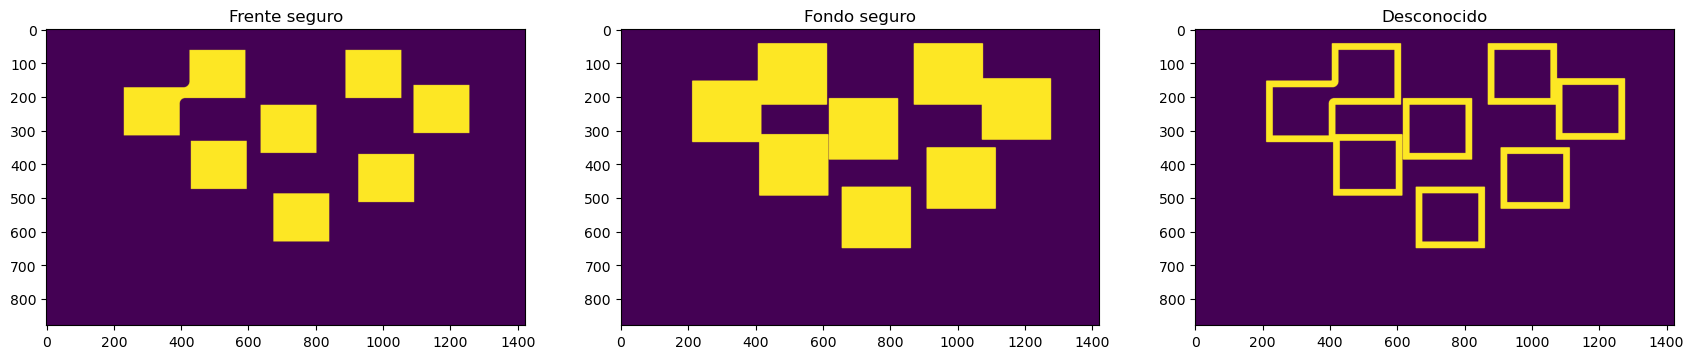

In [14]:
#3. Encontrar fondo y frente seguros
kernel = np.ones((3,3), np.uint8) #creamos una matriz de 1´s de 3x3 de 8 pixeles (por ser una imagen a blanco y negro necesita 255)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN, kernel, iterations=3) #erosion seguido dilatacion, 1 tipo de erosion que elimina el ruido de afuera

fondo_seguro =cv.dilate(opening,kernel,iterations=3) #dilate hace que las zonas blancas crezcan (expande los bordes de los objetos)
distancia_transformada = cv.distanceTransform(opening,cv.DIST_L2,5) #qué tan lejos está del píxel negro más cercano,(distancia euclidiana)
#calcula cada pixel vale la distancia hasta el pixel de fondo mas cercano.
#necesitamos ese dato para tener ese relieve que vamos a llenar con agua 

_, frente_seguro = cv.threshold(distancia_transformada,0.2*distancia_transformada.max(),255,0) #de la imagen solo selecciona los valores 
#se queda con los píx cuyo valor es mayor al 20% de la máxima distancia.255 valor asignado a los pix que superan el umbral blanco y binario simple
frente_seguro = np.uint8(frente_seguro) #tiene que transformar la imagen al tipo (0,255) porque cv2 necesita imagenes binarias y los marcadores necesitan eso
#el resultado de cv.dist_transform regresa un float
desconocido = cv.subtract(fondo_seguro,frente_seguro) #literal se sustrae el fondo de el frente 

plots([distancia_transformada,opening],["Distancia transformada","Opening"],"3. Encontrar fondo y frente seguros")
plots([frente_seguro, fondo_seguro,desconocido],["Frente seguro","Fondo seguro","Desconocido"],"")


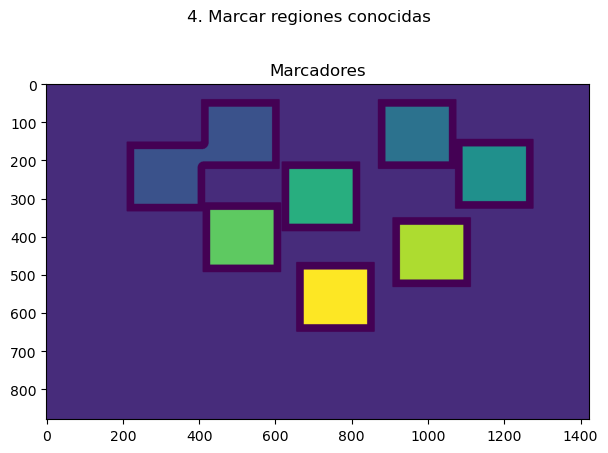

In [15]:
#4. Marcar regiones conocidas
_,marcadores =cv.connectedComponents(frente_seguro) #connectedComponents busca en el frente_seguro cada objeto separado y lo marca de forma int y distinta
marcadores = marcadores+1 # se hace esto porque el valor 0 se reserva para la region desconocida al aplicar el Watershed
marcadores[desconocido==255] =0 #encuentra los pixeles donde unkown vale 255 y le pone su marcador en 0

# 0 = region desconocida donde Watershed debe decidir como separar los objetos
plots([marcadores],["Marcadores"],"4. Marcar regiones conocidas")


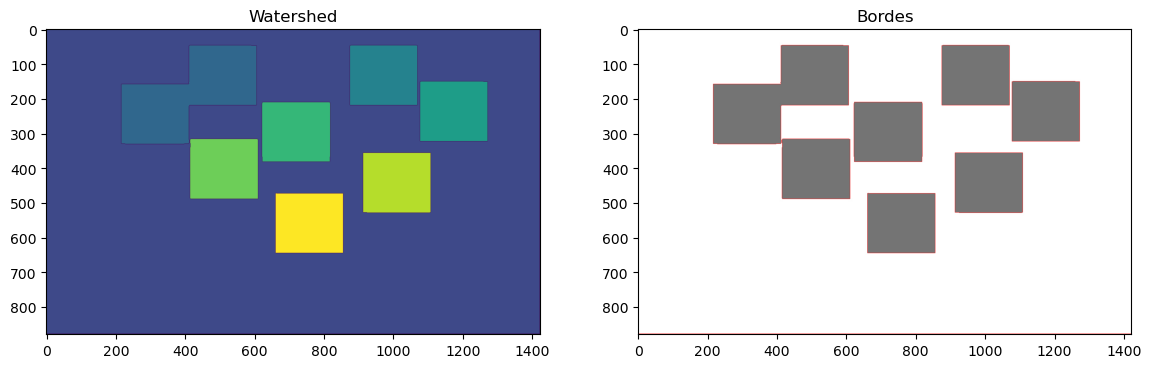

In [16]:
#5. Ejecutar el Watershed
watershed = cv.watershed(imgGris,marcadores) #recibe una imagen y un conjunto de marcadores
#lo que hace es que lo que este marcado como 0 son zona alta(montaña) y lo que es 1 es zona baja(valle). Al momento de "inundar" lo que
#se encuentre, sera una linea divisora y seran marcadas como un -1
#6. Dibujar bordes
imgGris[watershed == -1] =[255,0,0] #aqui indica que de la imagen lo que es -1 de watershed sera color rojo (RGB)
plots([watershed,imgGris], ["Watershed","Bordes"],"")
